In [1]:
from scipy.optimize import differential_evolution
import numpy as np
import json
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.style.use('seaborn-deep')
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
# import matplotlib.pyplot as plt
from MSC import *
%config Completer.use_jedi = False
showOriginalModelString = True

# load the samples from the original model
with open('observations.json') as json_file:
    observations = json.load(json_file)
# Set-up hyperparameters
class SETTINGS:
    free_params = {
        'TNF_a_l': [0,10],
        'K_IL6_prod_0':[0,1000],
        'K_IL6_prod_beta':[0,1000],
        'K_IL6_sat':[0,1000],
        'K_PGE2_prod_0':[0,1000],
        'K_PGE2_prod_beta':[0,1000],
        'K_PGE2_sat':[0,1000]
    }
    params = list(free_params.values())
    max_iters = 100


def cost_function(calib_params_values):
    
    # calculate the error for each tag by comparing the results to the original model
    ID_errors = []
    for ID in observations['IDs']:
        ID_setup_info = observations[ID]['setup']
        ID_observations = observations[ID]['expectations']
        # run the model
        model = MSC_model(SETTINGS.free_params.keys(),calib_params_values,ID_setup_info)
        results = model.run()
        tag_errors = []
        for tag,tag_observation in ID_observations.items():
            abs_diff =np.mean(abs(results[tag]-np.array(tag_observation)))
            means = [tag_observation,results[tag]]
            mean = np.mean(means)
            tag_error = abs_diff/mean
            
            # tag_error = np.mean(abs_diff)
            # print('tag {} abs_diff {} mean {} tag_error {}'.format(tag,abs_diff,mean,tag_error))
            tag_errors.append(tag_error)
        ID_errors.append(np.mean(tag_errors))
    return np.mean(ID_errors)

def optimize():
	# Call instance of PSO
	results = differential_evolution(cost_function,bounds=SETTINGS.params,disp=True,maxiter=SETTINGS.max_iters)
	return results


In [2]:
results = optimize()
print(results)
np.savetxt('inferred_values.csv',results.x,delimiter=",")

differential_evolution step 1: f(x)= 1.23551
differential_evolution step 2: f(x)= 1.23551
differential_evolution step 3: f(x)= 1.14824
differential_evolution step 4: f(x)= 1.04225
differential_evolution step 5: f(x)= 1.04225
differential_evolution step 6: f(x)= 1.00236
differential_evolution step 7: f(x)= 0.769442
differential_evolution step 8: f(x)= 0.769442
differential_evolution step 9: f(x)= 0.769442
differential_evolution step 10: f(x)= 0.769442
differential_evolution step 11: f(x)= 0.769442
differential_evolution step 12: f(x)= 0.769442
differential_evolution step 13: f(x)= 0.700396
differential_evolution step 14: f(x)= 0.700396
differential_evolution step 15: f(x)= 0.62157
differential_evolution step 16: f(x)= 0.444537
differential_evolution step 17: f(x)= 0.444537
differential_evolution step 18: f(x)= 0.444537
differential_evolution step 19: f(x)= 0.444537
differential_evolution step 20: f(x)= 0.444537
differential_evolution step 21: f(x)= 0.444537
differential_evolution step 2

In [3]:
inferred_values = np.loadtxt('inferred_values.csv')
ID_results = []
for ID in observations['IDs']:
    ID_setup_info = observations[ID]['setup']
    ID_observations = observations[ID]['expectations']
    # run the model
    model = MSC_model(SETTINGS.free_params.keys(),inferred_values,ID_setup_info)
    results = model.run()
    ID_results.append(results)

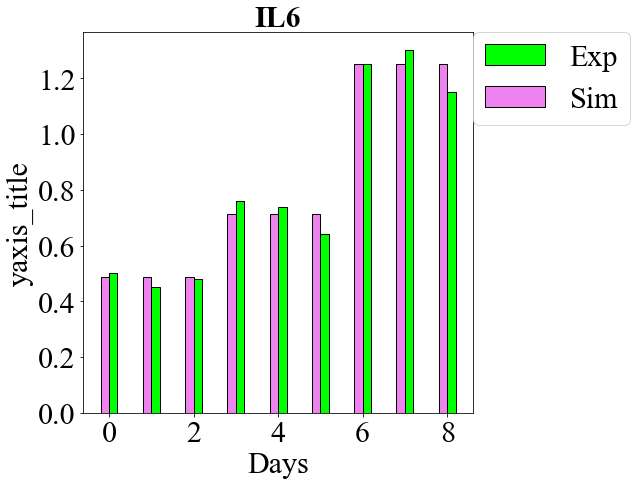

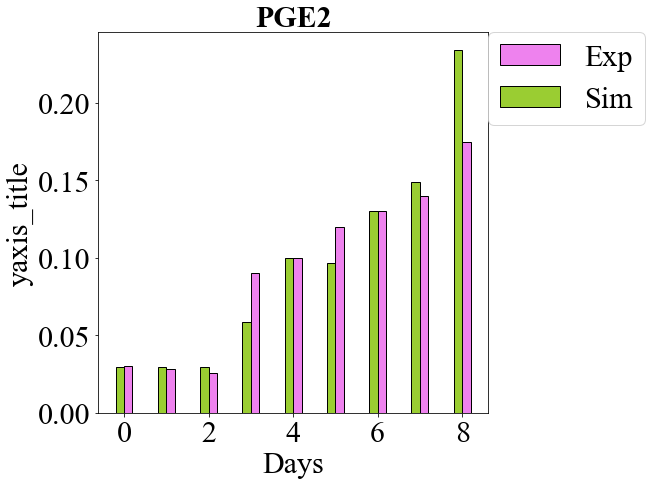

In [4]:
class GSs:
    graph_size = [7,7]
    targets = ['IL6','PGE2']
    bar_width = .2
    error_bar_width = .2
    colors = ['lime' , 'violet', 'yellowgreen', 'peru', 'skyblue']
    legend_font_size = 30
    tick_font_size = 30
    title_font_size = 30
    delta = .1 # gap between exp and sim


def sort():
    exp_tag_results = {}
    for tag in GSs.targets:
        exp_tag_results[tag] = []
    for tag in GSs.targets:
        for ID in observations['IDs']:
            ID_observations = observations[ID]['expectations']
            exp_tag_results[tag].append(ID_observations[tag])
    sim_tag_results = {}
    for tag in GSs.targets:
        sim_tag_results[tag] = []
    for tag in GSs.targets:
        for result in ID_results:
            sim_tag_results[tag].append(result[tag])
    return exp_tag_results,sim_tag_results
def bar_positions():
    for i in range(len(GSs.targets)):
        x_exp =[float(j) + GSs.delta for j in range(len(ID_results))]
        x_sim =[float(j) - GSs.delta for j in range(len(ID_results))]
    return x_exp,x_sim
exp_tag_results,sim_tag_results = sort()
x_exp,x_sim = bar_positions()
for tag,ii in zip(GSs.targets,range(len(GSs.targets))):
    fig = plt.figure(figsize=(GSs.graph_size[0],GSs.graph_size[1]))
    fig.canvas.draw()
    ax = fig.add_subplot(1, 1, 1)
    ax.bar(x=x_exp,height=exp_tag_results[tag],width = GSs.bar_width, label = 'Exp', facecolor = GSs.colors[ii],
             edgecolor="black", yerr =  0,
             error_kw = dict(capsize= GSs.error_bar_width))
    ax.bar(x=x_sim,height=sim_tag_results[tag],width = GSs.bar_width, label = "Sim", facecolor = GSs.colors[ii+1],
             edgecolor="black", yerr =  0,
             error_kw = dict(capsize= GSs.error_bar_width))
    ax.legend(bbox_to_anchor=(1.4, 1),loc = 'upper right', borderaxespad=0.,prop={ 'family':'Times New Roman','size':GSs.legend_font_size},ncol=1)
#     ax.set_ylim(yrange)
#     labels = [item.get_text() for item in ax.get_xticklabels()]
#     ax.set_xticks(ticks = [int(i) for i in x_labels])
#     ax.set_xticklabels(x_labels_adj)
#     ax.get_yaxis().set_major_formatter(
#         matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x)/1000, ',')))
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Times New Roman')
        label.set_fontsize(GSs.tick_font_size)
    ax.set_ylabel('yaxis_title',fontdict ={'family':'Times New Roman','size':GSs.title_font_size})
    ax.set_xlabel('Days',fontdict ={'family':'Times New Roman','size':GSs.title_font_size})
    
    ax.set_title(tag,fontdict ={'family':'Times New Roman','size':GSs.title_font_size, 'fontweight':'bold'})
